# Persister Cells

There are several ways that bacterial cells can survive antibiotic treatment. The better known scenario is bacterial resistance, in which cells mutate and become resistant to antibiotics. Another scenario, which is also very common, is bacterial persistence. The difference is that persistence is not caused by genetic mutations, and hence is not fully heritable. What happens is that a small fraction of the cell population enters a dormant state, such that they stop growing and, in the mean time, are insensitive to antibiotics. There is obviously a disadvantage for the cell population to have these cells (called "persisters"), as they do not grow or divide, hence do not contribute to the growth of the population. However, when antibiotics strike, these cells will survive, and will later exit the dormant state and grow to recover the cell population. Thus, persister cells act like an insurance policy for the bacterial population --- a certain amount of asset is set aside in case an unexpected disaster happens and everything else is lost. In layman's language, "don't put all eggs in one basket". In the finance jargon, it is called a "bet-hedging" strategy, as if you are betting on horses or stocks and you don't want to bet all your money on one option.

It is important to note that the persister cells are not a special subset of the cell population that are designated to be dormant. Rather, every cell has a certain probability of entering dormancy (at least for type-II persisters; type-I persiters are induced by stress). The question is, how many persisters should there be in a population? It is not always good (for the bacteria) to have more persisters. That is because, when there is no antibiotics, too many persisters means the population is not growing as fast as it can. On the other hand, too few persisters will not be able to protect the population from antibiotics. The right balance depends on how uncertain the environment is, i.e., how likely the bacterial population would encounter antibiotics. We will use a simple model to illustrate this point.

## Population growth in fluctuating environments

For simplicity, we will consider discrete time steps. In each time step, the environment can be in one of two conditions, either with or without antibiotics. Let us denote them by $\varepsilon = 0$ (no antibiotics) and $1$ (with antibiotics), respectively. Suppose that at every time step, the cell population always has the same fraction of persisters. Denote the cell types by $\phi = 0$ (normal) and $1$ (persister), and the proportions of normal and persister cells by $q_0$ and $q_1$. The growth of cells is determined by a fitness matrix, $f_{\phi\varepsilon}$, which represents how many cells will be produced by a cell type $\phi$ under environment $\varepsilon$ within a time step. Thus, for example, a normal cell in an antibiotics-free environment will give rise to $f_{00}$ cells in the next time step. Let us assume that normal cells all die under antibiotics, so $f_{01} = 0$. Furthermore, persister cells can survive antibiotics but do not grow, so $f_{10} = f_{11} = 1$.

Now suppose the current population size is $N_t$. Then there are $q_0 N_t$ normal cells and $q_1 N_t$ persisters. If the environment is $\varepsilon_t$, then at the next time step the population size will be:
\begin{equation}
N_{t+1} = N_t q_0 f_{0\varepsilon_t} + N_t q_1 f_{1\varepsilon_t} = N_t \sum_{\phi} q_\phi \, f_{\phi,\varepsilon_t}
\end{equation}
We will use this formula to simulate the population growth in randomly changing environments. For simplicity, we assume that at every time step, the environment is randomly chosen from $\varepsilon = 0$ and $1$ with probability $p_0$ and $p_1$, respectively.

Let us first write a python class to simulate the population growth in changing environments.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class BetHedging:
    """
    simulate bet-hedging strategy in changing environments.
    """
    
    def __init__(self, phe_dist, fit_mat, N0=1., record=True):
        """
        initialize population.
        inputs:
        phe_dist: 1-d array-like, phenotype distribution q[i] (should sum to 1).
        fit_mat: 2-d array-like, fitness matrix f[i,j] = number of offspring for phenotype i in environment j.
        N0: real, initial population size (use real instead of integer).
        record: bool, whether to record history of environment and population size.
        """
        self.phe_dist = np.asarray(phe_dist)    # phenotype distribution q_i
        self.fit_mat = np.asarray(fit_mat)    # fitness matrix f_{ij}
        self.pop_size = float(N0)    # current population size
        self.time = 0    # current number of generations since the beginning of simulation
        self.record = record
        if record:
            self.env_hist = []
            self.pop_hist = []
    
    def grow(self, env_seq):
        """
        simulation population growth in changing environments.
        inputs:
        env_seq: 1-d array-like, environment sequence, list of environment indices.
        """
        T = len(env_seq)
        for t in range(T):
            env = env_seq[t]    # environmental condition at each time step
            factor = np.dot(phe_dist, fit_mat[:,env])    # growth factor according to formula
            new_pop = self.pop_size * factor    # new population size at next time step
            if self.record:    # record history
                self.env_hist.append(env)
                self.pop_hist.append(self.pop_size)
            self.pop_size = new_pop    # update population size

Let us choose some parameter values. We already have $f_{01} = 0$ and $f_{10} = f_{11} = 1$; let us choose $f_{00} = 3$. Let the environment distribution be $p_0 = p_1 = 0.5$, which means both environments are equally likely. Then let us set the phenotype distribution to be $q_0 = 0.3$ and $q_1 = 0.7$, so that there are 70% persister cells. (These numbers are not realistic and only for illustration.)

In [3]:
env_dist = np.array([0.5, 0.5])    # environmental distribution
phe_dist = np.array([0.3, 0.7])    # phenotype distribution
fit_mat = np.array([[3., 0.],
                    [1., 1.]])    # fitness matrix

Now we generate a random sequence of environments and let the population grow.

In [4]:
T = 1000    # number of time steps
env_seq = np.random.choice(2, size=T, p=env_dist)    # choose random environment sequence according to distribution

N0 = 1.    # initial population size
bh1 = BetHedging(phe_dist, fit_mat, N0=N0, record=True)    # create bet-hedging population
bh1.grow(env_seq)    # grow population under given environmental sequence

Let us plot the population size on log scale.

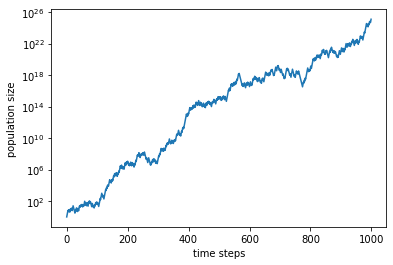

In [5]:
plt.figure()
plt.plot(bh1.pop_hist)
plt.yscale('log')
plt.xlabel('generations')
plt.ylabel('population size')
plt.show()

We see that, even though the population size fluctuates, it roughly increases linearly in log scale, i.e., exponentially with time. (Again, the numbers here are not realistic.) Let us find the slope of this trend, which gives the average growth rate:
\begin{equation}
\Lambda_T = \frac{1}{T} \, \log \frac{N_T}{N_0}
\end{equation}

In [6]:
lam_avg = np.log(bh1.pop_size / N0) / T    # average growth rate 
pop_avg = N0 * np.exp(lam_avg * np.arange(T))    # trend line

Theoretically, in the long term, the asymptotic growth rate is given by:
\begin{equation}
\Lambda = \lim_{T\to\infty} \Lambda_T = \sum_\varepsilon p_\varepsilon \log \Big( \sum_{\phi} q_\phi \, f_{\phi\varepsilon} \Big)
\end{equation}

In [7]:
lam_theory = np.dot(np.log(np.dot(phe_dist, fit_mat)), env_dist)    # asymptotic growth rate
pop_theory = N0 * np.exp(lam_theory * np.arange(T))    # theoretical trend line

Let us overlay these trend lines onto our simulation result.

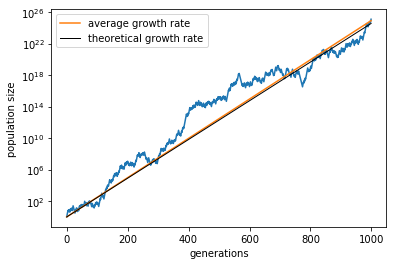

In [8]:
plt.figure()
plt.plot(bh1.pop_hist)
plt.plot(pop_avg, label='average growth rate')
plt.plot(pop_theory, 'k', lw=1, label='theoretical growth rate')
plt.yscale('log')
plt.xlabel('generations')
plt.ylabel('population size')
plt.legend()
plt.show()

## Optimal proportion of persisters

Let us now look for the optimal proportion of persisters in the cell population, which maximizes the long-term population growth rate. To find that, we need to simulate the population growth for different proportions of persisters.

In [9]:
q1_list = np.arange(0.01, 1, 0.01)    # list of values for q_1
lam_avg_list = []    # list to collect average growth rates
lam_theory_list = []    # list to collect theoretical growth rates

for q1 in q1_list:
    phe_dist = [1-q1, q1]
    bh1 = BetHedging(phe_dist, fit_mat, N0=N0, record=True)
    env_seq = np.random.choice(2, size=T, p=env_dist)
    bh1.grow(env_seq)
    lam_avg = np.log(bh1.pop_size / N0) / T    # simulation result
    lam_theory = np.dot(np.log(np.dot(phe_dist, fit_mat)), env_dist)    # theoretical result
    lam_avg_list.append(lam_avg)
    lam_theory_list.append(lam_theory)

<ipython-input-9-3aa55c178bf6>:10: RuntimeWarning: divide by zero encountered in log
  lam_avg = np.log(bh1.pop_size / N0) / T


We can plot the population growth rate with respect to the proportion of persisters.

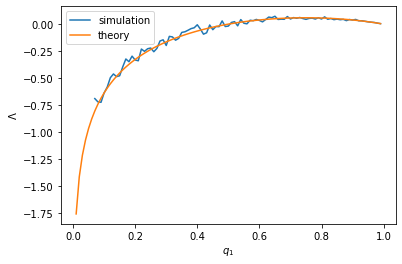

In [10]:
plt.figure()
plt.plot(q1_list, lam_avg_list, label='simulation')
plt.plot(q1_list, lam_theory_list, label='theory')
plt.xlabel(r'$q_1$')
plt.ylabel(r'$\Lambda$')
plt.legend()
plt.show()

It can be seen that the simulation results follow the theoretical values pretty closely. We will use the theoretical values to find the optimal proportion of persisters. This can be simply "read off" from the plot above.

In [11]:
imax = np.argmax(lam_theory_list)
print(f'optimal proportion of persisters = {q1_list[imax]}')
print(f'maximum growth rate = {lam_theory_list[imax]:.6f}')

optimal proportion of persisters = 0.75
maximum growth rate = 0.058892


The fact that the optimal proportion is reached at an intermediate value between 0 and 1 means that the cell population diversifies into a mixture of normal and persister cells. That is, a bet-hedging strategy is optimal!